In [1]:
# !pip install torch==1.9.0
# !pip install torchtext==0.10
# !pip install transformers==4.7
# !pip install fastai==2.4
# !pip install ipywidgets
# !pip install rjieba

In [2]:
from fastai.text.all import *
import pandas as pd

In [3]:
path = '../Data/balanced_clean_data.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
# binary_df = df[df['Score'] != 0]

In [6]:
# binary_df = binary_df.replace([-1, 1], [0, 1])

In [7]:
# df.head()

In [8]:
df['Score'] = df['Score'].replace([-1, 0, 1], [0, 2, 1])

In [9]:
# df['Score'] = pd.get_dummies(df['Score'])

In [10]:
# df['Score'].shape

In [11]:
# train_df = binary_df[:int(len(binary_df) * 0.75)]
# test_df = binary_df[int(len(binary_df) * 0.75) : len(binary_df)]

train_df = df[:int(len(df) * 0.75)]
test_df = df[int(len(df) * 0.75) : len(df)]

In [12]:
len(train_df), len(test_df)

(11691, 3897)

## Binary

In [13]:
## BINARY

## from transformers import AutoTokenizer, AutoModelForSequenceClassification

## hf_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
## hf_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')  92.6% accuracy

## from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

## hf_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
## hf_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') 93.3% accuracy 

## from transformers import AutoTokenizer, AutoModelForSequenceClassification

## hf_tokenizer = AutoTokenizer.from_pretrained("huggingface/distilbert-base-uncased-finetuned-mnli")
## hf_model = AutoModelForSequenceClassification.from_pretrained("huggingface/distilbert-base-uncased-finetuned-mnli") 92.2% accuracy



## MULTI-CLASS

In [14]:
## MULTI-CLASS

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

hf_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', do_lower_case = True)
hf_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels = 3) 
# 74.4% accuracy

# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# hf_tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased')
# hf_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

In [15]:
sample_text = train_df['Text'][0]
# sample_text

In [16]:
tokenizer_outputs = hf_tokenizer(sample_text, return_tensors= 'pt')
# tokenizer_outputs

In [17]:
tokenizer_outputs['input_ids'].shape, tokenizer_outputs['attention_mask'].shape

(torch.Size([1, 198]), torch.Size([1, 198]))

In [18]:
class HF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, hf_tokenizer):
        self.df = df
        self.hf_tokenizer = hf_tokenizer
        
    def __len__(self):
        return len(self.df)
    
    def decode(self, token_ids):
        return ' '.join([hf_tokenizer.decode(x) for x in tokenizer_outputs['input_ids']])
    
    def decode_to_original(self, token_ids):
        return self.hf_tokenizer.decode(token_ids.squeeze())
    
    def __getitem__(self, index):
        label, text = self.df.iloc[index]
        label = torch.tensor(label)
        
        tokenizer_output = self.hf_tokenizer(text, return_tensors = 'pt', padding = 'max_length', truncation = True, max_length = 512)
        tokenizer_output['input_ids'].squeeze_()
        tokenizer_output['attention_mask'].squeeze_()
        
        return tokenizer_output, label

In [ ]:
train_dataset = HF_Dataset(train_df, hf_tokenizer)
test_dataset = HF_Dataset(test_df, hf_tokenizer)
len(train_dataset), len(test_dataset)

(11691, 3897)

In [19]:
train_dataset = HF_Dataset(train_df, hf_tokenizer)
test_dataset = HF_Dataset(test_df, hf_tokenizer)
len(train_dataset), len(test_dataset)

(11691, 3897)

In [20]:
tokenizer_outputs, label = train_dataset[0]
tokenizer_outputs.keys(), label

(dict_keys(['input_ids', 'attention_mask']), tensor(1))

In [21]:
# train_dataset.decode(tokenizer_outputs['input_ids'])[:500]

In [22]:
# train_dataset.decode_to_original(tokenizer_outputs['input_ids'])[:500]

In [23]:
train_dl = DataLoader(train_dataset, bs = 16, shuffle = True)
test_dl = DataLoader(test_dataset, bs = 16)

dls = DataLoaders(train_dl, test_dl)

In [24]:
train_dl = DataLoader(train_dataset, bs = 16, shuffle = True)
test_dl = DataLoader(test_dataset, bs = 16)

dls = DataLoaders(train_dl, test_dl)

In [25]:
batched_data, batched_labels = train_dl.one_batch()
batched_data.keys(), batched_data['input_ids'].shape, batched_labels.shape

(dict_keys(['input_ids', 'attention_mask']),
 torch.Size([16, 512]),
 torch.Size([16]))

In [26]:
class HF_Model(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        
        self.hf_model = hf_model
    
    def forward(self, tokenizer_outputs):
        model_output = self.hf_model(**tokenizer_outputs)
        
        return model_output.logits

In [27]:
model = HF_Model(hf_model)

In [28]:
learn = Learner(dls, model.to('cuda'), loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], )


SuggestedLRs(valley=tensor(2.0893e-05))

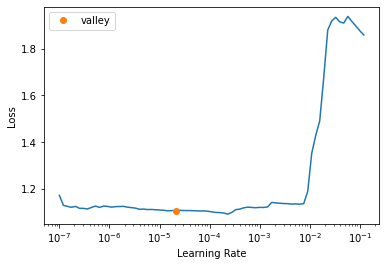

In [29]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20,2.0893e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.751210,0.742151,0.660251,23:30
1,0.618867,0.623646,0.726200,23:29
2,0.575288,0.592440,0.744932,23:25
3,0.476123,0.673450,0.716962,23:28
4,0.393884,0.638825,0.745702,23:29
5,0.308868,0.707170,0.750064,23:29
6,0.187973,0.935471,0.740313,23:30
7,0.134823,0.985481,0.733641,23:25
8,0.092805,1.119056,0.744162,23:23
